In [1]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import torch

In [3]:
# Disable WandB completely
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
data = pd.read_csv('/content/twitter_training.csv', encoding='utf-8')

data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [5]:
# Create a new column "lable" from the third column in the data
data["lable"] = data.iloc[:, 2:3]

In [6]:
# Extract the "review" from the fourth (text) column
data["review"] = data.iloc[:, 3:4]

In [7]:
# data["lable"].unique()

# Map the sentiment labels to numerical values:
# "Positive" - 3, "Neutral" - 2, "Irrelevant" -- 1, "Negative" - 0

data["lable_mapped"] = data["lable"].map({"Positive": 3, "Neutral": 2, 'Irrelevant':1, "Negative": 0}).astype(int)

In [8]:
# Drop any rows with missing values
data.dropna(inplace=True)

In [9]:
# Count the number of instances for each sentiment label
count = data.groupby("lable")["lable"].count()

<Axes: xlabel='lable'>

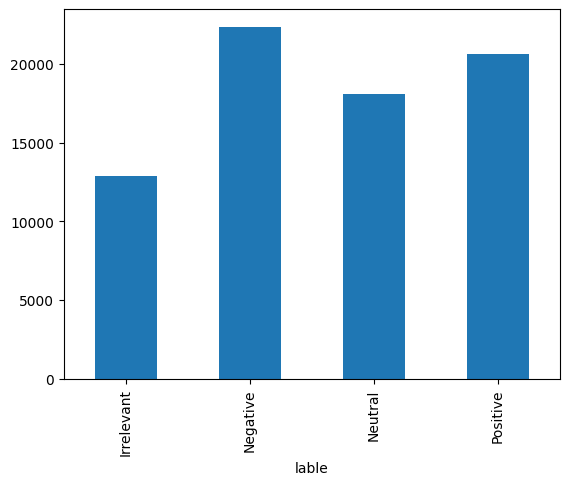

In [10]:
# Plot the distribution of sentiment labels
count.plot(kind="bar", label="Count of sentiments")

In [11]:
# Split and assign the data into features (X) and labels (y)
X = data["review"]
y = data["lable_mapped"]

In [12]:
# Split the data into training and testing sets (80% training, 20% testing)
train, test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Initialize the BERT tokenizer and model for sequence classification
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Define a function to tokenize the text data
def tokenize(text):
  return(
      tokenizer(
          text.tolist(),
          padding=True,
          max_length=128,
          truncation=True,
          return_tensors="pt"
      )
  )

In [15]:
# Tokenize the training and testing data
train_encoding = tokenize(train)
test_encoding = tokenize(test)

In [16]:
# Define a custom dataset class for the tokenized data
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels.iloc[idx])
        }

    def __len__(self):
        return len(self.labels)

In [17]:
# Create the dataset for training and testing
train_dataset = SimpleDataset(train_encoding, y_train)
test_dataset = SimpleDataset(test_encoding, y_test)

In [18]:
# Define the training arguments for the model training process
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    report_to="none",
    save_strategy="no"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
# Define a custom function for accuracy data
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [20]:
# Initialize the Trainer with the model, training arguments, and datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [21]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.614400,0.544078,0.820731
2,0.289700,0.436680,0.893574
3,0.146400,0.381267,0.918711


TrainOutput(global_step=22200, training_loss=0.46003426027727556, metrics={'train_runtime': 4677.2355, 'train_samples_per_second': 37.969, 'train_steps_per_second': 4.746, 'total_flos': 1.1681551288922112e+16, 'train_loss': 0.46003426027727556, 'epoch': 3.0})

In [22]:
# # Evaluate the model
results = trainer.evaluate()
# print(f"Evaluation Results: {results}")

In [23]:
print(f"\nEvaluation Accuracy: {results['eval_accuracy']:.4f}")
print(f"Evaluation Loss: {results['eval_loss']:.4f}")


Evaluation Accuracy: 0.9187
Evaluation Loss: 0.3813


In [56]:
# Save the trained model and tokenizer to disk for later use
trainer.save_model("./saved_bert_model")  # This saves the model
tokenizer.save_pretrained("./saved_bert_tokenizer")  # This saves the tokenizer

print("Model and tokenizer saved successfully")


Model and tokenizer saved successfully


In [57]:
# Reload the saved model and tokenizer for future use
from transformers import BertTokenizer, BertForSequenceClassification

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/saved_bert_tokenizer')

# Load the saved model
model = BertForSequenceClassification.from_pretrained('/content/saved_bert_model')

# Confirm successful loading of the model and tokenizer
print("Model and tokenizer loaded successfully.")

Model and tokenizer loaded successfully.


In [61]:
# Function to make predictions
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits).item()

    # Mapping predicted class to sentiment
    label_map = {3: "Positive", 2: "Neutral", 1: "Irrelevant", 0: "Negative"}
    return label_map[predicted_class]

In [63]:
# Example usage
sample_text = "I love this."
prediction = predict_sentiment(sample_text)
print(f"Predicted Sentiment: {prediction}")


Predicted Sentiment: Positive


In [65]:
# Example usage
sample_text = "something wrong here! I hate this place."
prediction = predict_sentiment(sample_text)
print(f"Predicted Sentiment: {prediction}")


Predicted Sentiment: Negative
